In [14]:
%%capture c
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import math
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import seaborn as sns
from typing_extensions import Literal

!pip install torch-summary
from torchsummary import summary

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [16]:
train = pd.read_csv("../input/digit-recognizer/train.csv")

<AxesSubplot:xlabel='label', ylabel='count'>

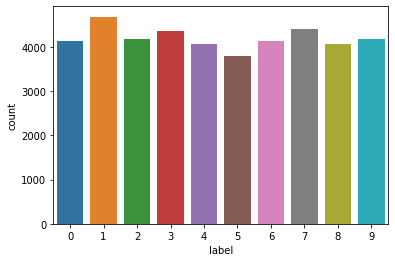

In [17]:
sns.countplot(x = train['label'])

<AxesSubplot:xlabel='label', ylabel='count'>

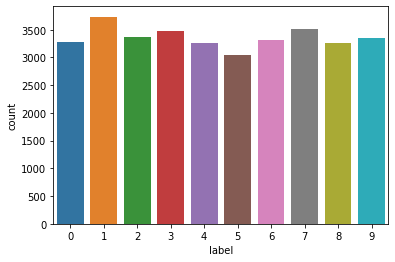

In [18]:
sns.countplot(x = train.iloc[:int(len(train)*0.8)]['label'])

In [19]:
class Augments:
    @staticmethod
    def gaussian_noise(img, sigma = 0.05):
        return img + torch.randn_like(img) * sigma

    @staticmethod
    def zoom(img):
        paddings = [math.floor(28*0.05)]*2
        dimensions = [math.ceil(28 - paddings[0]*2)]*2
        return transforms.functional.resized_crop(
            img, *paddings, *dimensions, size = 28)
        
class MnistDataset(Dataset):    
    def __init__(self, train_split = 0.8, aug : Literal["online", "offline", "stock"] = "online") -> None:
        train = pd.read_csv("../input/digit-recognizer/train.csv")
        # for training
        n_samples = int(train.shape[0] * train_split)
        self.x = self.transform(torch.from_numpy(train.values[:n_samples, 1:])/255)
        self.y = torch.from_numpy((pd.get_dummies(train[:n_samples].label, prefix = "Label")).values)/1.0

        # generate augment data
        self.augments = [
#             transforms.Lambda(Augments.gaussian_noise),
            transforms.RandomRotation(degrees = 10.0),
            # shift left/right by 10% (range bound)
            transforms.RandomAffine(degrees = 0.0, translate = (0.1,0.1)), 
            transforms.Lambda(Augments.zoom)
        ]
        
        if aug == "online":
            self.x, self.y = self._inflate_data_vanila(self.x, self.y)
        elif aug == "offline":
            self.x, self.y = self._inflate_data_aug(self.x, self.y)
        self.stop_aug = aug in ("offline", "stock")
        
        # for validation
        self.x_validation = self.transform(torch.from_numpy(train.values[n_samples:, 1:])/255)
        self.y_validation = train.values[n_samples:, :1]
        self.y_validation_onehot = torch.from_numpy((pd.get_dummies(train[n_samples:].label, prefix = "Label")).values)/1.0

    def transform(cls, tensor):
        return tensor.reshape((-1, 1, 28, 28)) # greyscale 28 x 28 image
        # return tensor 

    def get_validation_set(self):
        return self.x_validation , self.y_validation

    def _random_aug(self,x):
        chance = 0.5
        
        if torch.rand(1) < chance:
            aug = self.augments[torch.randint(len(self.augments), (1,))]
            return aug(x)
        return x
    
    def __getitem__(self, index):
        if self.stop_aug:
            return self.x[index], self.y[index]
        return self._random_aug(self.x[index]), self.y[index]

    def __len__(self):
        return self.x.shape[0]
    
    """Inflate data by 'frac' amount"""
    def _inflate_data_vanila(self,x,y, frac = 0.2):
        indices = torch.randint(
            x.shape[0], size = (1, int(x.shape[0] * frac)) )
        indices = indices[0]
        return torch.cat((x, x[indices])), torch.cat((y, y[indices]))
    
    """Augment data to inflate the dataset"""
    def _inflate_data_aug(self, x, y):
        fractions = [
            0.2, 0.2, 0.1
        ]
        assert len(fractions) == len(self.augments), "should be as many fractions as augments for offline aug"
        for aug, frac in zip(self.augments, fractions):
            indices = torch.randint(x.shape[0], size = (1, int(x.shape[0] * frac)) )
            x = torch.cat((x, aug(x[indices[0]])))
            y = torch.cat((y, y[indices[0]]))
            
        return x, y
        

In [20]:
class ConvModel(nn.Module):
    def __init__(self) -> None:
        super(ConvModel, self).__init__()

        output_size = 10 # 10 digits recognition

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1),
            nn.BatchNorm2d(4),
            nn.Mish(),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=5, stride=3),
            nn.BatchNorm2d(16),
            nn.Mish(),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=8, stride=1),
            nn.Mish(),
            nn.BatchNorm2d(64),
            nn.Flatten()
        )

        self.fc = nn.Linear(64, output_size)

        # apply he / kaiming normal weight init
        self.apply(self._he_normal)

    def _he_normal(self, x):
        if isinstance(x, nn.Linear) or isinstance(x, nn.Conv2d) or isinstance(x, nn.Conv1d):
            nn.init.kaiming_normal_(x.weight)
            x.bias.data.zero_()

    def forward(self, x):
        return self.fc(self.conv(x))

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            res =  self.forward(x).argmax(dim=1)
        self.train()
        return res

In [21]:
batch_size = int(math.pow(2,9))
dataset = MnistDataset()
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle=True, num_workers = os.cpu_count())
print(f'batch size = {batch_size}')
print(f'dataset size = {len(dataset)}')

batch size = 512
dataset size = 40320


In [22]:
x_validation, y_validation = dataset.get_validation_set()

def get_acc(model, do_print=False):
    corr = 0
    prediction = model.predict(x_validation)
    for i in range(len(y_validation)):
        if prediction[i].item() == y_validation[i].item():
            corr+=1
    acc = corr/len(y_validation) * 100
    if do_print:
        print(f'accracy = {acc:.4f}%')
    return acc
            
def train(model, dataloader, epochs = 7, ft = False, learning_rate = None):
    # hyper params
    max_lr = 0.3
    learning_rate = max_lr * 1e-3 if learning_rate == None else learning_rate
    step = max(epochs//10,1)

    # setup model
    sgd = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)
    adam = torch.optim.RAdam(model.parameters(), 
                                lr = learning_rate)
    optimizer = adam

    loss = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                    max_lr = max_lr, 
                                                    steps_per_epoch = len(dataloader),
                                                    epochs = epochs)

    # training
    best_acc = -math.inf
    for epoch in range(epochs):
        for index, (x_batch, y_batch) in enumerate(dataloader):
            y_hat = model(x_batch)
            l = loss(y_hat, y_batch)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            if not ft:
                scheduler.step()
             
        # restore best acc
        acc = get_acc(model, do_print = False)
        if acc > best_acc:
            best_acc = acc
            best_state = model.state_dict()

#         if (epoch + 1) % step == 0:
        print(f'{epoch+1}. loss = {l:.6f} ; accuracy = {acc:.3f}')
            
    restored_model = ConvModel()
    restored_model.load_state_dict(best_state)
    return restored_model

In [23]:
print(ConvModel())
summary(ConvModel(), input_size = (batch_size, 1, 28, 28));

ConvModel(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): Conv2d(4, 16, kernel_size=(5, 5), stride=(3, 3))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Mish()
    (6): Conv2d(16, 64, kernel_size=(8, 8), stride=(1, 1))
    (7): Mish()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       40
|    └─BatchNorm2d: 2-2                  8
|    └─Mish: 2-3                         --
|    └─Conv2d: 2-4                       1,616
|    └─BatchNorm2d: 2-5                  32
|    └─Mish: 2-6                         --
|    └─Conv2d

In [24]:
%%time
"""Train"""
model = train(ConvModel(), dataloader, epochs = 20)
get_acc(model, do_print = True)

1. loss = 0.257598 ; accuracy = 95.131
2. loss = 0.099312 ; accuracy = 96.714
3. loss = 0.143934 ; accuracy = 94.917
4. loss = 0.063848 ; accuracy = 88.881
5. loss = 0.050908 ; accuracy = 97.464
6. loss = 0.111279 ; accuracy = 55.548
7. loss = 0.051587 ; accuracy = 97.345
8. loss = 0.071329 ; accuracy = 97.179
9. loss = 0.068862 ; accuracy = 98.012
10. loss = 0.109022 ; accuracy = 97.738
11. loss = 0.025244 ; accuracy = 97.917
12. loss = 0.045112 ; accuracy = 98.036
13. loss = 0.039695 ; accuracy = 96.643
14. loss = 0.013258 ; accuracy = 98.750
15. loss = 0.035071 ; accuracy = 98.988
16. loss = 0.023958 ; accuracy = 98.988
17. loss = 0.002743 ; accuracy = 98.952
18. loss = 0.000536 ; accuracy = 99.083
19. loss = 0.001541 ; accuracy = 99.048
20. loss = 0.012256 ; accuracy = 99.095
accracy = 99.0952%
CPU times: user 3min 58s, sys: 15.1 s, total: 4min 13s
Wall time: 2min 13s


99.09523809523809

In [25]:
"""Make submission"""
sub = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
x_sub = dataset.transform(torch.tensor(pd.read_csv("../input/digit-recognizer/test.csv").values /255, dtype = torch.float32))
pred = model.predict(x_sub)
sub['Label'] = pred
sub.to_csv("submission.csv", index = False)
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


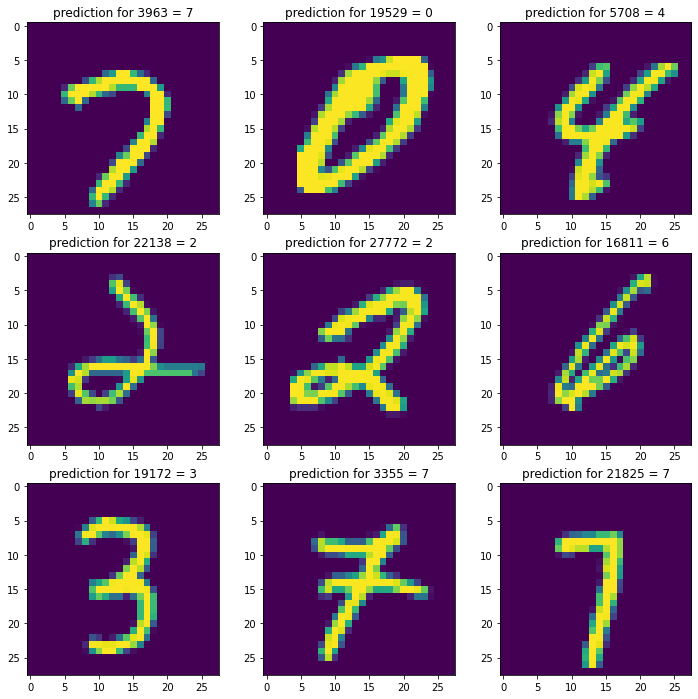

In [26]:
"""Sanity check predictions"""
n_rows = 3
fig, axs = plt.subplots(n_rows, n_rows, figsize = (12,12))

predictions = []
for _ in range(n_rows ** 2):
    i = random.randint(0,len(x_sub))
    target = x_sub[i:i+1]
    img = target[0][0]
    predictions.append((f'prediction for {i} = {model.predict(target).item()}', img))

for (txt, img), ax in zip(predictions, axs.flat):
    ax.imshow(img)
    ax.title.set_text(txt)
plt.show()